<a href="https://colab.research.google.com/github/asantos2000/master-degree-santos-anderson/blob/main/code/src/chap_7_validation_elements_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation

Validation of algorithms and transformation results.

Chap 7. Validação
- Section 7.3 Resultados
    - Section 7.3.2 Semantic Annotation
        - Extração de regras operativas, fatos, termos e nomes

> To run again, restore checkpoint directory with files from `checkpoints_extract` directory.

## Google colab

In [2]:
%load_ext autoreload
%autoreload 2

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !rm -rf cfr2sbvr configuration checkpoint
  !git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr
  %pip install -r cfr2sbvr/code/requirements.txt
  !cp -r cfr2sbvr/code/src/configuration .
  !cp -r cfr2sbvr/code/src/checkpoint .
  !cp -r cfr2sbvr/code/config.colab.yaml config.yaml
  DEFAULT_CONFIG_FILE="config.yaml"
else:
  DEFAULT_CONFIG_FILE="../config.yaml"

## Imports

In [3]:
# Standard library imports
from collections import defaultdict
from datetime import datetime
import json
import time
from typing import List
import os
import re
from collections import Counter

# Third-party imports
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from openai import OpenAI
from scipy.spatial.distance import cosine
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import xlsxwriter
from openpyxl import load_workbook
import openpyxl
from pydantic import BaseModel, Field
from deepdiff import DeepSearch


# Local application/library-specific imports
import checkpoint.main as checkpoint
from checkpoint.main import (
    normalize_str,
    restore_checkpoint,
    get_all_checkpoints,
    Document,
)
import configuration.main as configuration
import logging_setup.main as logging_setup
import token_estimator.main as token_estimator
from token_estimator.main import estimate_tokens
import llm_query.main as llm_query
from llm_query.main import query_instruct_llm

DEV_MODE = True

if DEV_MODE:
    # Development mode
    import importlib

    importlib.reload(configuration)
    importlib.reload(logging_setup)
    importlib.reload(checkpoint)
    importlib.reload(token_estimator)
    importlib.reload(llm_query)

# # Ensure plots are displayed inline if using a Jupyter notebook
# %matplotlib inline

# from IPython.display import display

## Settings

### Configuration

In [4]:
# Load configuration
config = configuration.load_config(DEFAULT_CONFIG_FILE)

### Logging

In [5]:
logger = logging_setup.setting_logging(config["DEFAULT_LOG_DIR"], config["LOG_LEVEL"])

2025-01-11 17:39:08 - INFO - Logging is set up with daily rotation.


## Checkpoints

### Restore the checkpoint

In [7]:
# Restore the checkpoint

# To run after extraction
last_checkpoint = configuration.get_last_filename(
    config["DEFAULT_CHECKPOINT_DIR"], "documents", "json"
)

logger.info(f"{last_checkpoint=}")

config["DEFAULT_CHECKPOINT_FILE"] = last_checkpoint

manager = restore_checkpoint(filename=config["DEFAULT_CHECKPOINT_FILE"])

2025-01-11 17:39:39 - INFO - last_checkpoint='../data/checkpoints/documents-2025-01-11-10.json'
2025-01-11 17:39:39 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-10.json
2025-01-11 17:39:39 - INFO - Checkpoint restored from ../data/checkpoints/documents-2025-01-11-10.json.


## General functions

In [8]:
def group_and_count_not_in_true(pred_terms_list, true_terms_list):
    # Dictionary to store counts of terms not in true_terms_list
    not_in_true_counts = defaultdict(int)

    # Iterate through pred_terms_list
    for term in pred_terms_list:
        if term not in true_terms_list:
            not_in_true_counts[term] += 1

    # Sort the dictionary by key (term) in ascending order and return it
    sorted_counts = dict(sorted(not_in_true_counts.items(), key=lambda x: x[0]))
    return sorted_counts

In [9]:
def extract_index_and_key(s):
    # Define a regular expression pattern to match the index and key
    pattern = r"root\[(\d+)\]\['(\w+)'\]"

    # Use re.match to find the pattern in the string
    match = re.match(pattern, s)

    if match:
        # Extract the index and key from the match groups
        index = int(match.group(1))
        key = match.group(2)
        return index, key
    else:
        raise ValueError("String format is incorrect")

In [10]:
def save_metrics_to_excel(dataframes_list, output_excel_path):
    """
    Saves multiple DataFrames to an Excel file, each as a separate sheet.

    Args:
        dataframes_list (list): List of tuples, where each tuple contains:
            - sheet_name (str): The name of the sheet.
            - dataframe (DataFrame): The DataFrame to save.
        output_excel_path (str): Path to save the Excel file.

    Returns:
        None
    """
    # Clean up sheet names to contain only letters, spaces, and numbers
    sanitized_dataframes = [
        (re.sub(r"[^A-Za-z0-9 ]+", "", sheet_name).strip(), df)
        for sheet_name, df in dataframes_list
    ]

    # Determine the mode to use based on whether the file exists
    mode = "a" if os.path.exists(output_excel_path) else "w"

    if mode == "a":
        # Load existing workbook
        book = load_workbook(output_excel_path)
        with pd.ExcelWriter(output_excel_path, mode=mode, engine="openpyxl") as writer:
            # Use the existing workbook
            writer.book = book
            writer.sheets = {ws.title: ws for ws in book.worksheets}

            # Remove sheets if they already exist
            for sheet_name, _ in sanitized_dataframes:
                if sheet_name in writer.sheets:
                    del book[sheet_name]

            # Write the new dataframes
            for sheet_name, df in sanitized_dataframes:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
    else:
        # Create a new workbook
        with pd.ExcelWriter(output_excel_path, mode=mode, engine="openpyxl") as writer:
            for sheet_name, df in sanitized_dataframes:
                df.to_excel(writer, sheet_name=sheet_name, index=False)

In [11]:
def check_for_definitions_similarity(
    true_terms_classify, pred_terms_classify, threshold=0.8
):
    """
    Compare terms from true_terms_classify and pred_terms_classify, ensuring alignment by doc_id and statement_id.
    Calculate similarity scores for matching definitions without duplicates in the results.
    """
    results = []
    unique_results = set()  # Track unique entries
    matched_terms = 0

    # Convert true_terms_classify into a dictionary for easier matching
    true_terms = {
        f"{term['doc_id']}|{term['sources']}|{term['statement_id'].strip().lower()}": term.get(
            "statement", ""
        )
        for term in true_terms_classify
    }

    # Iterate through pred_terms_classify to compare with true_terms
    for pred_term in pred_terms_classify:
        pred_doc_id = pred_term["doc_id"]
        pred_statement_id = pred_term["statement_id"].strip().lower()
        pred_definition = pred_term.get("definition", "")
        pred_sources = pred_term["sources"]

        # Construct the key for matching
        pred_key = f"{pred_doc_id}|{pred_sources}|{pred_statement_id}"

        # Check if the term exists in true_terms
        if pred_key in true_terms:
            true_statement = true_terms[pred_key]

            logger.debug(pred_definition, true_statement)

            if not pred_definition and not true_statement:
                similarity_score = 1
            elif not pred_definition and true_statement:
                similarity_score = 0
            elif pred_definition and not true_statement:
                similarity_score = -1
            else:
                # Compute similarity between definitions
                score = jellyfish.levenshtein_distance(pred_definition, true_statement)
                max_length = max(len(pred_definition), len(true_statement), 1)
                similarity_score = 1 - (score / max_length)

            logger.debug(pred_definition, "|", true_statement, "|", similarity_score)

            # Construct a unique identifier for the result to avoid duplicates
            result_key = (
                f"{pred_doc_id}|{pred_sources}|{pred_statement_id}|{similarity_score}"
            )

            if result_key not in unique_results:
                # Add the unique key to the set
                unique_results.add(result_key)

                # Check if similarity exceeds the threshold
                if similarity_score >= threshold:
                    matched_terms += 1
                    results.append(
                        {
                            "doc_id": pred_doc_id,
                            "sources": pred_sources,
                            "term": pred_statement_id,
                            "definition_pred": pred_definition,
                            "definition_true": true_statement,
                            "similarity_score": similarity_score,
                        }
                    )
                else:
                    results.append(
                        {
                            "doc_id": pred_doc_id,
                            "sources": pred_sources,
                            "term": pred_statement_id,
                            "definition_pred": pred_definition,
                            "definition_true": true_statement,
                            "similarity_score": similarity_score,
                        }
                    )
        else:
            # Log unmatched terms for debugging
            logger.debug(f"Unmatched pred_term: {pred_key}")

    logger.info(f"Total terms in true_terms: {len(true_terms_classify)}")
    logger.info(f"Total matched terms in pred_terms: {matched_terms}")

    return results

In [12]:
def create_terms_results_heatmap(df_terms_results):
    # Handle duplicate entries by aggregating similarity scores
    df_terms_results = df_terms_results.groupby(["term", "doc_id"], as_index=False).agg(
        {"similarity_score": "mean"}
    )

    # Pivot the DataFrame to create a matrix of terms vs. documents
    df_pivot = df_terms_results.pivot(
        index="term", columns="doc_id", values="similarity_score"
    )

    # Limit the number of terms for readability (e.g., top 50 terms)
    if df_pivot.shape[0] > 50:
        df_pivot = df_pivot.head(50)

    # Generate the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_pivot, cmap="coolwarm", linewidths=0.5, annot=True)
    plt.title("Heatmap of Similarity Scores")
    plt.xlabel("Document ID")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

In [13]:
def get_terms_with_definitions(manager, doc_type="true_table"):
    """
    Read the true terms from the true tables and merge definitions from P2 documents.

    Args:
        manager (DocumentManager): The DocumentManager instance.

    Returns:
        list: A list of true terms with definitions, without duplicates.
    """
    docs_ids = manager.list_document_ids()

    terms_sources_p1 = {}
    definitions_p2 = {}

    # Iterate over P1 documents to collect terms
    for doc_id in docs_ids:
        normalized_doc_id = normalize_str(doc_id)
        if normalized_doc_id.startswith("§") and normalized_doc_id.endswith("_P1"):
            doc = manager.retrieve_document(doc_id, doc_type)
            logger.debug(f"{doc=}")
            for element in doc.content.get("elements"):
                logger.debug(f"{element=}")
                for term in element.get("terms"):
                    logger.debug(f"{term=}")
                    statement_id = term.get("term", "")
                    sources = tuple(element.get("sources", []))  # Use tuple for immutability in keys
                    composite_key = (doc_id.replace("_P1", ""), sources, statement_id)

                    if composite_key not in terms_sources_p1:  # Avoid duplicates
                        terms_sources_p1[composite_key] = {
                            "statement_id": statement_id,
                            "classification": term.get("classification", ""),
                            "sources": sources,
                            "doc_id": normalized_doc_id.replace("_P1", ""),
                            "definition": None,  # Placeholder for definition from P2
                        }

    logger.info(f"Total count: {len(terms_sources_p1)} terms P1")

    # Iterate over P2 documents to collect definitions
    for doc_id in docs_ids:
        normalized_doc_id = normalize_str(doc_id)
        if normalized_doc_id.startswith("§") and normalized_doc_id.endswith("_P2"):
            doc = manager.retrieve_document(doc_id, doc_type)
            logger.debug(f"{doc_id=}, {doc=}")
            for term in doc.content.get("terms"):
                logger.debug(f"{term=}")
                statement_id = term.get("term", "")
                definition = term.get("definition", None)
                sources = tuple(term.get("sources", []))  # Ensure sources match the structure in P1
                composite_key = (doc_id.replace("_P2", ""), sources, statement_id)

                if composite_key not in definitions_p2:  # Avoid duplicates
                    definitions_p2[composite_key] = definition

    logger.info(f"Total count: {len(definitions_p2)} terms with definitions P2")

    # Merge definitions from P2 into the terms collected from P1
    for composite_key, term in terms_sources_p1.items():
        if composite_key in definitions_p2:
            term["definition"] = definitions_p2[composite_key]

    result = list(terms_sources_p1.values())  # Convert dictionary back to list
    logger.info(f"Count: {len(result)} terms with merged definitions")
    logger.debug(f"{result=}")

    return result


In [14]:
def get_pred_elements(checkpoint_dir):
    """
    Get predicted elements from checkpoints.

    Args:
        checkpoint_dir: Directory containing checkpoints.

    Returns:
        List of predicted elements.
    """
    managers, file_info_list = get_all_checkpoints(checkpoint_dir)

    logger.info(f"Loaded {len(managers)} checkpoints")

    pred_elements = []

    for manager, file_info in zip(managers, file_info_list):
        docs_ids = manager.list_document_ids(doc_type="llm_response")

        logger.info(
            f"Processing {len(docs_ids)}, {docs_ids=} documents from {file_info=}"
        )

        for doc_id in docs_ids:
            if doc_id.startswith("§") and doc_id.endswith("_P1"):
                logger.info(f"Processing {doc_id}")
                doc = manager.retrieve_document(doc_id, "llm_response")
                logger.debug(f"{doc_id=}")

                for element in doc.content.get("elements"):
                    logger.debug(f'{element.get("id")=}')
                    pred_elements.append(
                        {
                            "doc_id": doc.id.replace("_P1", ""),
                            "id": element.get("id"),
                            "title": element.get("title"),
                            "statement": element.get("statement"),
                            "classification": element["classification"],
                            "sources": f'{doc.content.get("section")}{element.get("sources")}',
                            "filename": file_info.get("filename"),
                        }
                    )
            else:
                logger.info(f"Skipping {doc_id}")

        logger.info(f"{doc_id}: total of elements: {len(pred_elements)}")

    logger.info(f"Processed all documents - total {len(pred_elements)} elements")

    return pred_elements

In [15]:
def get_true_elements(manager):
    """
    Read the true elements from the true tables.

    Args:
        manager (DocumentManager): The DocumentManager instance.

    Returns:
        list: A list of true elements.
    """
    docs_ids = manager.list_document_ids(doc_type="true_table")

    true_elements = []

    for doc_id in docs_ids:
        if doc_id.startswith("§") and doc_id.endswith("_P1"):
            doc = manager.retrieve_document(doc_id, "true_table")
            logger.debug(f"{doc_id=}, {doc=}")

            for element in doc.content.get("elements"):
                true_elements.append(
                    {
                        "doc_id": doc.id.replace("_P1", ""),
                        "id": element.get("id"),
                        "statement": element.get("statement"),
                        "classification": element["classification"],
                        "sources": f'{doc.content.get("section")}{element.get("sources")}',
                    }
                )

    logger.info(f"Count: {len(true_elements)} elements")

    return true_elements

In [16]:
jellyfish.levenshtein_distance("Anderson", "Luiz")

8

In [17]:
# Function to group statements by doc_id
def group_statements_by_doc_id(statements_list, is_pred=False):
    doc_id_map = defaultdict(list)
    for item in statements_list:
        doc_id = item["doc_id"]
        if is_pred:
            # Include filename, id, and classification for pred_list items
            statement_info = {
                "id": item["id"],
                "statement": item["statement"],
                "classification_pred": item.get("classification", None),
                "sources_pred": item["sources"],
                "filename_pred": item["filename"],
            }
        else:
            # Include id and classification for true_list items
            statement_info = {
                "id": item["id"],
                "statement": item["statement"],
                "classification_true": item.get("classification", None),
                "source_true": item["sources"],
            }
        doc_id_map[doc_id].append(statement_info)

    logger.debug(f"doc_id_map: {doc_id_map}")

    return doc_id_map


# Function to check the similarity between true and pred statements grouped by doc_id
def check_for_statements_similarity(true_list, pred_list, threshold=0.7):
    # Build mappings from doc_id to list of statements
    true_statements_by_doc_id = group_statements_by_doc_id(true_list)
    pred_statements_by_doc_id = group_statements_by_doc_id(pred_list, is_pred=True)

    results = []
    all_doc_ids = set(true_statements_by_doc_id.keys()).union(
        pred_statements_by_doc_id.keys()
    )

    for doc_id in all_doc_ids:
        true_statements = true_statements_by_doc_id.get(doc_id, [])
        pred_statements = pred_statements_by_doc_id.get(doc_id, [])

        for pred_item in pred_statements:
            pred_expr = pred_item["statement"]
            pred_id = pred_item["id"]
            classification_pred = pred_item.get("classification_pred", None)
            source_pred = pred_item["sources_pred"]
            filename_pred = pred_item["filename_pred"]

            best_match = None
            best_score = 0
            best_true_id = None
            classification_true = None

            for true_item in true_statements:
                true_expr = true_item["statement"]
                true_id = true_item["id"]
                source_true = true_item["source_true"]
                # Calculate the similarity score using the Levenshtein distance
                score = jellyfish.levenshtein_distance(pred_expr, true_expr)
                similarity_score = 1 - (
                    score / max(len(pred_expr), len(true_expr))
                )  # Normalize to a similarity score

                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = true_expr
                    best_true_id = true_id
                    best_source = source_true
                    classification_true = true_item.get("classification_true", None)
            results.append(
                {
                    "doc_id": doc_id,
                    "id_pred": pred_id,
                    "id_true": best_true_id,
                    "classification_pred": classification_pred,
                    "classification_true": classification_true,
                    "source_pred": source_pred,
                    "source_true": best_source,
                    "filename_pred": filename_pred,
                    "statement_pred": pred_expr,
                    "statement_true": best_match,
                    "similarity_score": best_score,
                }
            )
    return results

#
# Fix the number of comparisons true vs pred
#
# def group_true_by_doc_id(true_items):
#     grouped = {}
#     for t in true_items:
#         doc_id = t["doc_id"]
#         if doc_id not in grouped:
#             grouped[doc_id] = []
#         grouped[doc_id].append(t)
#     return grouped

# def group_pred_by_doc_id_and_filename(pred_items):
#     grouped = {}
#     for p in pred_items:
#         doc_id = p["doc_id"]
#         filename = p.get("filename") or p.get("filename_pred", "no_filename")
#         key = (doc_id, filename)
#         if key not in grouped:
#             grouped[key] = []
#         grouped[key].append(p)
#     return grouped

# def check_for_statements_similarity(true_list, pred_list):
#     # Group the true items by doc_id
#     true_by_doc = group_true_by_doc_id(true_list)
    
#     # Group the predicted items by (doc_id, filename)
#     pred_by_doc_filename = group_pred_by_doc_id_and_filename(pred_list)
    
#     # Collect all doc_ids that appear in either set
#     all_doc_ids = set(true_by_doc.keys())
#     for (doc_id, _) in pred_by_doc_filename.keys():
#         all_doc_ids.add(doc_id)
    
#     results = []

#     for doc_id in all_doc_ids:
#         # Get the full list of true items for this doc_id
#         true_items = true_by_doc.get(doc_id, [])
        
#         # Collect all filenames that appear in the predictions for this doc_id
#         # (We look for all keys whose first element matches this doc_id)
#         filenames_for_doc = []
#         for (d_id, fname) in pred_by_doc_filename.keys():
#             if d_id == doc_id:
#                 filenames_for_doc.append(fname)
        
#         # If there are no predicted filenames at all for this doc_id,
#         # produce rows with empty predicted info for each true item
#         if not filenames_for_doc:
#             for t_item in true_items:
#                 results.append({
#                     "doc_id": doc_id,
#                     "id_true": t_item["id"],
#                     "statement_true": t_item["statement"],
#                     "classification_true": t_item.get("classification"),
#                     "source_true": t_item.get("sources"),
#                     "filename_pred": None,
#                     "id_pred": None,
#                     "statement_pred": None,
#                     "classification_pred": None,
#                     "source_pred": None,
#                     "similarity_score": 0.0
#                 })
#             # Move on to next doc_id
#             continue
        
#         # For each filename, produce exactly one row per true item
#         # picking the best matching prediction (if any)
#         for filename in filenames_for_doc:
#             # The predicted items for this (doc_id, filename)
#             pred_items = pred_by_doc_filename.get((doc_id, filename), [])
            
#             for t_item in true_items:
#                 true_expr = t_item["statement"]
#                 best_score = 0.0
#                 best_pred = None  # best matching predicted item

#                 # If no predicted items, we will store empty values below
#                 for p_item in pred_items:
#                     pred_expr = p_item["statement"]
#                     distance = jellyfish.levenshtein_distance(pred_expr, true_expr)
#                     max_len = max(len(pred_expr), len(true_expr))
#                     similarity = 1 - (distance / max_len) if max_len else 0
                    
#                     if similarity > best_score:
#                         best_score = similarity
#                         best_pred = p_item

#                 if best_pred:
#                     # We found a best matching predicted statement
#                     results.append({
#                         "doc_id": doc_id,
#                         "id_true": t_item["id"],
#                         "statement_true": t_item["statement"],
#                         "classification_true": t_item.get("classification"),
#                         "source_true": t_item.get("sources"),
#                         "filename_pred": filename,
#                         "id_pred": best_pred["id"],
#                         "statement_pred": best_pred["statement"],
#                         "classification_pred": best_pred.get("classification_pred", 
#                                                               best_pred.get("classification")),
#                         "source_pred": best_pred.get("sources_pred", best_pred.get("sources")),
#                         "similarity_score": best_score
#                     })
#                 else:
#                     # No predicted items or no matches for this filename
#                     results.append({
#                         "doc_id": doc_id,
#                         "id_true": t_item["id"],
#                         "statement_true": t_item["statement"],
#                         "classification_true": t_item.get("classification"),
#                         "source_true": t_item.get("sources"),
#                         "filename_pred": filename,
#                         "id_pred": None,
#                         "statement_pred": None,
#                         "classification_pred": None,
#                         "source_pred": None,
#                         "similarity_score": 0.0
#                     })

#     return results

# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return "identical"
    elif score >= 0.9:
        return "close-match"
    else:
        return "not-sure"


# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == "identical":
        color = "green"
    elif val == "close-match":
        color = "yellow"
    else:
        color = "red"
    return f"background-color: {color}"

In [18]:
def create_df_elements_results(similarity_elements_results):
    # Build the dataframe
    df_results = pd.DataFrame(similarity_elements_results)

    df_results["similarity_classification"] = df_results["similarity_score"].apply(
        classify_similarity
    )

    df_results["classification_match"] = (
        df_results["classification_pred"] == df_results["classification_true"]
    )
    df_results["classification_match_label"] = df_results["classification_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["source_match"] = df_results["source_pred"] == df_results["source_true"]
    df_results["source_match_label"] = df_results["source_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["id_match"] = df_results["id_pred"] == df_results["id_true"]
    df_results["id_match_label"] = df_results["id_match"].map(
        {True: "match", False: "mismatch"}
    )

    return df_results

In [19]:
def create_df_elements_results_confusion_matrix_classification(df_elements_results):
    # Prepare the data
    df_elements_evaluation = df_elements_results.dropna(
        subset=["classification_true", "classification_pred"]
    )

    y_true = df_elements_evaluation["classification_true"]
    y_pred = df_elements_evaluation["classification_pred"]

    # Get the unique labels from both y_true and y_pred
    labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")
    plt.title("Matrix de confusão para classificação")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n")
    print(report)

In [20]:
def create_elements_results_distribution_similarity(df_elements_results):
    # Assuming you already have similarity_counts
    similarity_elements_counts = df_elements_results[
        "similarity_classification"
    ].value_counts()

    # Calculating the total number of classifications
    total_counts = similarity_elements_counts.sum()

    # Plotting the distribution
    fig, ax = plt.subplots(
        figsize=(10, 6)
    )  # Increase the figure size for better visibility
    ax = similarity_elements_counts.plot(
        kind="bar", color=["green", "yellow", "blue"], edgecolor="black"
    )

    # Adding chart title and axis labels
    plt.title("Distribuição de Classificações de Similaridade", fontsize=16)
    plt.xlabel("Classificações de Similaridade", fontsize=14)
    plt.ylabel("Contagem", fontsize=14)

    # Adding count and percentage on each bar in the same line
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total_counts * 100
        ax.annotate(
            f"{count} ({percentage:.1f}%)",
            (
                p.get_x() + p.get_width() / 2.0,
                count,
            ),  # Position slightly above the bar for clarity
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
        )

    # Optimizing axes labels and tick sizes
    plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better readability
    plt.yticks(fontsize=12)

    # Adding grid lines for better visual reference
    plt.grid(axis="y", linestyle="--", linewidth=0.3)

    plt.tight_layout()  # Adjust the padding for cleaner look
    plt.show()

In [21]:
def create_df_elements_results_confusion_matrix_source(df_elements_results):
    # Prepare the data
    df_elements_evaluation = df_elements_results.dropna(
        subset=["source_true", "source_pred"]
    )

    y_true = df_elements_evaluation["source_true"]
    y_pred = df_elements_evaluation["source_pred"]

    # Get the unique labels from both y_true and y_pred
    labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")
    plt.title("Matrix de confusão para origem")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n")
    print(report)

In [22]:
def create_elements_results_distribution_source(df_elements_results):
    # Assuming you already have similarity_counts
    similarity_elements_counts = df_elements_results["source_match"].value_counts()

    # Calculating the total number of classifications
    total_counts = similarity_elements_counts.sum()

    # Plotting the distribution
    fig, ax = plt.subplots(
        figsize=(10, 6)
    )  # Increase the figure size for better visibility
    ax = similarity_elements_counts.plot(
        kind="bar", color=["green", "red"], edgecolor="black"
    )

    # Adding chart title and axis labels
    plt.title("Distribuição de Classificações de origem", fontsize=16)
    plt.xlabel("Classificações de origem", fontsize=14)
    plt.ylabel("Contagem", fontsize=14)

    # Adding count and percentage on each bar in the same line
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total_counts * 100
        ax.annotate(
            f"{count} ({percentage:.1f}%)",
            (
                p.get_x() + p.get_width() / 2.0,
                count,
            ),  # Position slightly above the bar for clarity
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
        )

    # Optimizing axes labels and tick sizes
    plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better readability
    plt.yticks(fontsize=12)

    # Adding grid lines for better visual reference
    plt.grid(axis="y", linestyle="--", linewidth=0.3)

    plt.tight_layout()  # Adjust the padding for cleaner look
    plt.show()

In [23]:
def create_df_terms_results(similarity_terms_results):
    # Step 1: Load similarity_results into a DataFrame
    df_terms_results = pd.DataFrame(similarity_terms_results)

    return df_terms_results

In [24]:
def create_terms_results_distribution_similarity(df_terms_results):
    # Plot a Histogram of Similarity Scores
    plt.figure(figsize=(10, 6))
    plt.hist(
        df_terms_results["similarity_score"],
        bins=20,
        edgecolor="black",
        color="skyblue",
    )
    plt.xlabel("Similarity Score")
    plt.ylabel("Number of Terms")
    plt.title("Distribution of Similarity Scores")
    plt.grid(axis="y")
    plt.show()

In [25]:
def create_terms_results_histogram_low_similarity(df_terms_results, number_of_terms=10):
    df_low_similarity = df_terms_results.sort_values(by="similarity_score").head(
        number_of_terms
    )

    plt.figure(figsize=(12, 6))
    plt.barh(
        df_low_similarity["term"], df_low_similarity["similarity_score"], color="salmon"
    )
    plt.xlabel("Similarity Score")
    plt.ylabel("Term")
    plt.title("Terms with Lowest Similarity Scores")
    plt.gca().invert_yaxis()  # Invert y-axis to have the lowest score at the top
    plt.show()

In [26]:
def create_terms_results_average_similarity_per_document(df_terms_results):
    doc_similarity = (
        df_terms_results.groupby("doc_id")["similarity_score"].mean().reset_index()
    )

    print("Average Similarity Score per Document:")
    display(doc_similarity)

    # Plot average similarity score per document
    plt.figure(figsize=(12, 6))
    plt.bar(
        doc_similarity["doc_id"], doc_similarity["similarity_score"], color="skyblue"
    )
    plt.xlabel("Document ID")
    plt.ylabel("Average Similarity Score")
    plt.title("Average Similarity Score per Document")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## Datasets

From section 7.2.4 Datasets

The datasets used in this chapter are mentioned in the respective algorithm as true and predicted lists.

### Sample size

Margin of error for estimating the mean.

In [24]:
import math

# Level for 95% confidence
Z = 1.96

# The algorithm ran 10 times
n = 10

# Standard deviation
sigma = 0.1

# Error margin calculation
E = (Z * sigma) / math.sqrt(n)

f"Error margin: {round(E * 100, 2)}%"


'Error margin: 6.2%'

### True tables

Get true values from all runs

In [27]:
true_tables_manager = restore_checkpoint(
    filename=f'{config["DEFAULT_DATA_DIR"]}/documents_true_table.json'
)

logger.info(f"Loaded {len(true_tables_manager.list_document_ids())} documents")

2025-01-11 17:39:52 - INFO - DocumentManager restored from file: ../data/documents_true_table.json
2025-01-11 17:39:52 - INFO - Checkpoint restored from ../data/documents_true_table.json.
2025-01-11 17:39:52 - INFO - Loaded 14 documents


Documents in true table's file.

In [28]:
true_tables_manager.list_document_ids(doc_type="true_table")

['§ 275.0-2_P1',
 '§ 275.0-2_P2',
 '§ 275.0-5_P1',
 '§ 275.0-5_P2',
 '§ 275.0-7_P1',
 '§ 275.0-7_P2',
 'classify_P1',
 'classify_P2_Operative_rules',
 'classify_P2_Definitional_terms',
 'classify_P2_Definitional_names',
 'classify_P2_Definitional_facts']

Elements true table for validate P1 extraction prompt

In [29]:
true_elements_extraction = get_true_elements(true_tables_manager)

2025-01-11 17:40:01 - INFO - Count: 22 elements


In [30]:
Counter([item['classification'] for item in true_elements_extraction])

Counter({'Fact Type': 16, 'Operative Rule': 6})

Terms true table for validate P2 extraction prompt

In [31]:
true_all_terms = get_terms_with_definitions(true_tables_manager, "true_table")

true_terms_extraction = [
    term for term in true_all_terms if term["classification"] == "Common Noun"
]

true_names_extraction = [
    term for term in true_all_terms if term["classification"] == "Proper Noun"
]

2025-01-11 17:40:04 - INFO - Total count: 136 terms P1


2025-01-11 17:40:04 - INFO - Total count: 84 terms with definitions P2
2025-01-11 17:40:04 - INFO - Count: 136 terms with merged definitions


In [32]:
logger.info(f"Operative rules and facts: {len(true_elements_extraction)}")
logger.info(f"Terms: {len(true_terms_extraction)}")
logger.info(f"Names: {len(true_names_extraction)}")

2025-01-11 17:40:07 - INFO - Operative rules and facts: 22
2025-01-11 17:40:07 - INFO - Terms: 122
2025-01-11 17:40:07 - INFO - Names: 14


In [33]:
Counter([item['classification'] for item in true_all_terms])

Counter({'Common Noun': 122, 'Proper Noun': 14})

### Predicted values

Get predicted elements from all runs

Predict elements from P1 extraction prompt.

In [34]:
pred_elements_extraction = get_pred_elements(config["DEFAULT_CHECKPOINT_DIR"])

2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-1.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-10.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-2.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-3.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-4.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-5.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-6.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-7.json
2025-01-11 17:40:18 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-

In [35]:
print(Counter([item['classification'] for item in true_elements_extraction]))
print(Counter([item['classification'] for item in pred_elements_extraction]))

Counter({'Fact Type': 16, 'Operative Rule': 6})
Counter({'Fact Type': 175, 'Operative Rule': 42})


In [36]:
logger.info(
    f"True elements: {len(true_elements_extraction)}, Pred elements: {len(pred_elements_extraction)}"
)

2025-01-11 17:41:59 - INFO - True elements: 22, Pred elements: 217


Predict terms from P2 extraction prompt.

In [37]:
managers, file_info_list = get_all_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])

logger.info(f"Loaded {len(managers)} checkpoints")

#pred_terms = {}
pred_all_terms = []

for pred_tables_manager, file_info in zip(managers, file_info_list):
    # pred_tables_manager = restore_checkpoint(
    #     filename=f'{config["DEFAULT_DATA_DIR"]}/checkpoints/documents-2024-12-07-1.json'
    # )

    logger.info(f"Loaded {len(pred_tables_manager.list_document_ids())} documents")

    pred_all_terms.extend(get_terms_with_definitions(pred_tables_manager, "llm_response"))

2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-1.json


2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-10.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-2.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-3.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-4.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-5.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-6.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-7.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2025-01-11-8.json
2025-01-11 17:42:04 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-

In [38]:
pred_terms_extraction = [
    term for term in pred_all_terms if term["classification"] == "Common Noun"
]

pred_names_extraction = [
    term for term in pred_all_terms if term["classification"] == "Proper Noun"
]
logger.info(f"Terms: {len(pred_terms_extraction)}")
logger.info(f"Names: {len(pred_names_extraction)}")

2025-01-11 17:42:09 - INFO - Terms: 1049


2025-01-11 17:42:09 - INFO - Names: 128


## Algorithms

Validation of algorithm from section 6.2 Implementation of main components

Source for section 7.3 Results 

### semantic annotation

#### Extract elements

Validating results from chap_6_semantic_annotation_elements_extraction.ipynb

- Extract elements by type: Terms, facts, fact type, or operative rules
- Extract term's definition
- Identify elements source

##### Extract elements: Operative Rules and Fact Types (P1)

Compare true and pred elements by its statement using levenshtein distance (Levenshtein distance (LIND-COMBS et al., 2023; FAROUK, 2019))

In [39]:
similarity_elements_results = check_for_statements_similarity(
    true_elements_extraction, pred_elements_extraction
)

Create a dataframe of true and pred elements

In [40]:
df_elements_results = create_df_elements_results(similarity_elements_results)
# Save the dataframe to an Excel file
df_elements_results.to_excel(
    f'{config["DEFAULT_OUTPUT_DIR"]}/p1_true_pred_results.xlsx'
)

Display the First 10 Rows

In [41]:
# Select the first 10 rows from df_results
df_top10 = df_elements_results.head(10)

# Apply the styling to the sliced DataFrame using .map
styled_elements_df_top10 = df_top10.style.map(
    highlight_similarity, subset=["similarity_classification"]
)
styled_elements_df_top10.set_table_attributes(
    'style="width: 100%; border: 1px solid black;"'
)
styled_elements_df_top10.set_properties(**{"border": "1px solid black"})

# Display the styled DataFrame (if in Jupyter Notebook)
display(styled_elements_df_top10)

,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,statement_pred,statement_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
0,§ 275.0-2,1,1,Fact Type,Fact Type,§ 275.0-2['(a)'],§ 275.0-2['(a)'],documents-2025-01-11-1.json,"A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.","A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.",1.000000,identical,True,match,True,match,True,match
1,§ 275.0-2,2,2,Fact Type,Fact Type,§ 275.0-2['(a)(1)'],§ 275.0-2['(a)(1)'],documents-2025-01-11-1.json,"A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.","A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.",1.000000,identical,True,match,True,match,True,match
2,§ 275.0-2,3,3,Fact Type,Operative Rule,§ 275.0-2['(a)(2)'],§ 275.0-2['(a)(2)'],documents-2025-01-11-1.json,"If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.","If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.",1.000000,identical,False,mismatch,True,match,True,match
3,§ 275.0-2,4,4,Fact Type,Operative Rule,§ 275.0-2['(a)(3)'],§ 275.0-2['(a)(3)'],documents-2025-01-11-1.json,"If the Secretary certifies that the Commission was served with process, pleadings, or other papers pursuant to paragraph (a)(1) of this section and forwarded these documents to a named party pursuant to paragraph (a)(2) of this section, this certification constitutes evidence of service upon that party.","If the Secretary certifies that the Commission was served with process, pleadings, or other papers pursuant to paragraph (a)(1) of this section and forwarded these documents to a named party pursuant to paragraph (a)(2) of this section, this certification constitutes evidence of service upon that party.",1.000000,identical,False,mismatch,True,match,True,match
4,§ 275.0-2,5,5,Fact Type,Fact Type,§ 275.0-2['(b)(1)'],§ 275.0-2['(b)(1)'],documents-2025-01-11-1.json,"Managing agent means any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.","Managing agent means any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.",1.000000,identical,True,match,True,match,True,match
5,§ 275.0-2,6,6,Fact Type,Fact Type,§ 275.0-2['(b)(2)'],§ 275.0-2['(b)(2)'],documents-2025-01-11-1.json,Non-resident means an individual who resides in any place not subject to the jurisdiction of the United States; a corporation that is incorporated in or that has its principal office and place of busines

**Type classification**

Computing the confusion matrix and classification report of the evaluation results of predicted classifications against true classifications.

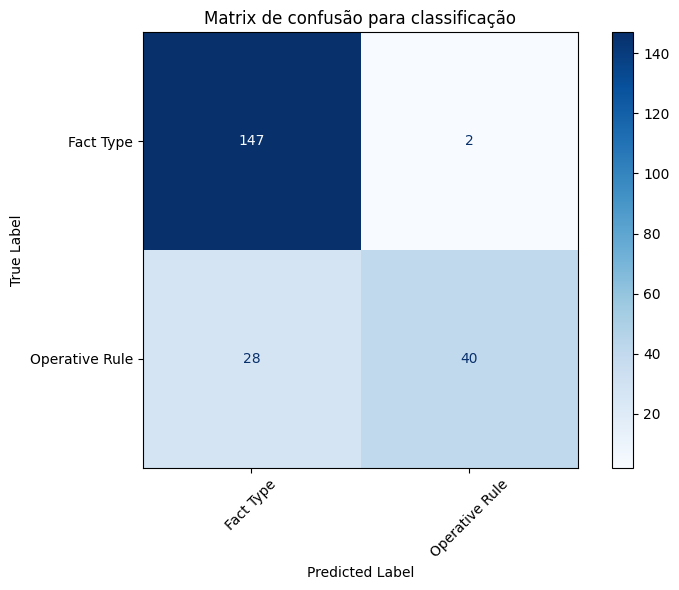

Classification Report:

                precision    recall  f1-score   support

     Fact Type     0.8400    0.9866    0.9074       149
Operative Rule     0.9524    0.5882    0.7273        68

      accuracy                         0.8618       217
     macro avg     0.8962    0.7874    0.8173       217
  weighted avg     0.8752    0.8618    0.8510       217



In [42]:
# To get per doc_id use the filtered_df
#filtered_df = df_elements_results[df_elements_results['doc_id']=='§ 275.0-7']
filtered_df = df_elements_results # not filtered
create_df_elements_results_confusion_matrix_classification(filtered_df)

Analyzing the Distribution of Similarity Classifications

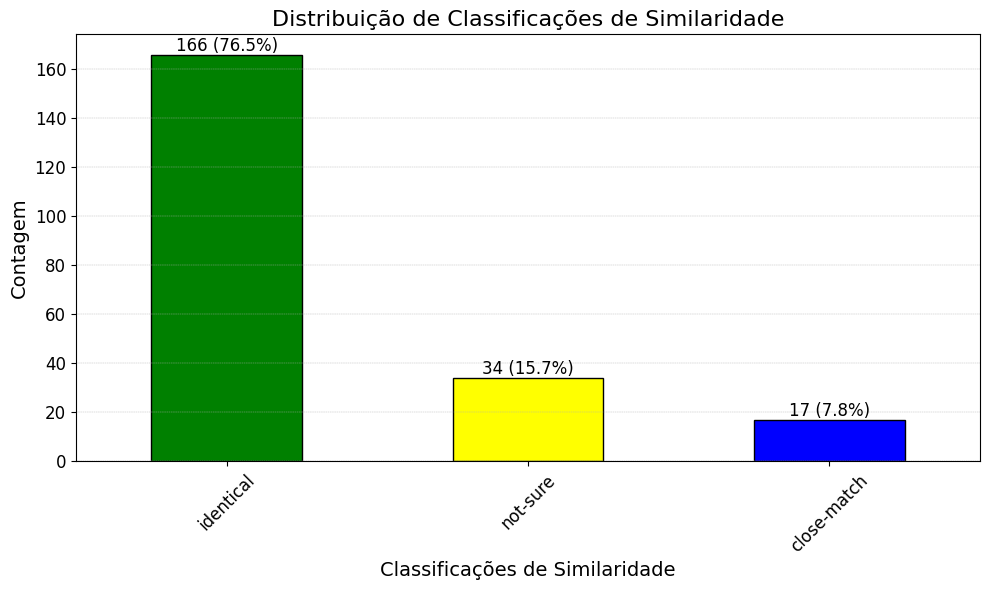

In [43]:
create_elements_results_distribution_similarity(df_elements_results)

In [44]:
df_elements_results.query("0.75 <= similarity_score <= 1").shape[0]

183

In [45]:
df_elements_results[df_elements_results["similarity_classification"] == "not-sure"].describe()

,id_pred,id_true,similarity_score
count,34.000000,34.000000,34.000000
mean,3.558824,3.823529,0.504344
std,1.812268,1.217812,0.132309
min,1.000000,2.000000,0.301724
25%,2.000000,3.250000,0.420635
50%,4.000000,4.000000,0.464029
75%,5.000000,4.000000,0.599485
max,7.000000,6.000000,0.715517


In [46]:
df_misaligned_similarity=df_elements_results[df_elements_results["similarity_classification"] == "not-sure"].sort_values(by="similarity_score", ascending=True)

# Export the filtered and sorted DataFrame to an Excel file
output_file_path = f'{config["DEFAULT_OUTPUT_DIR"]}/misaligned_similarity.xlsx'
df_misaligned_similarity.to_excel(output_file_path, index=False)

df_misaligned_similarity

,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,statement_pred,statement_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
77,§ 275.0-5,6,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(2)'],§ 275.0-5['(c)'],documents-2025-01-11-10.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.301724,not-sure,True,match,False,mismatch,False,mismatch
123,§ 275.0-5,6,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(2)'],§ 275.0-5['(c)'],documents-2025-01-11-9.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.301724,not-sure,True,match,False,mismatch,False,mismatch
106,§ 275.0-5,6,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(2)'],§ 275.0-5['(c)'],documents-2025-01-11-6.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.301724,not-sure,True,match,False,mismatch,False,mismatch
84,§ 275.0-5,6,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(2)'],§ 275.0-5['(c)'],documents-2025-01-11-2.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.306034,not-sure,True,match,False,mismatch,False,mismatch
122,§ 275.0-5,5,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(1)'],§ 275.0-5['(c)'],documents-2025-01-11-9.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.396552,not-sure,True,match,False,mismatch,False,mismatch
76,§ 275.0-5,5,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(1)'],§ 275.0-5['(c)'],documents-2025-01-11-10.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.396552,not-sure,True,match,False,mismatch,False,mismatch
105,§ 275.0-5,5,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(1)'],§ 275.0-5['(c)'],documents-2025-01-11-6.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.396552,not-sure,True,match,False,mismatch,False,mismatch
83,§ 275.0-5,5,4,Operative Rule,Operative Rule,§ 275.0-5['(c)(1)'],§ 275.0-5['(c)'],documents-2025-01-11-2.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.400862,not-sure,True,match,False,mismatch,False,mismatch
145,§ 275.0-7,2,2,Fact Type,Fact Type,§ 275.0-7['(a)(1)'],§ 275.0-7['(a)(1)'],documents-2025-01-11-2.json,An investment adviser has assets under managem...,An investment adviser has assets under managem...,0.420635,not-sure,True,match,True,match,True,match
181,§ 275.0-7,2,2,Fact Type,Fact Type,§ 275.0-7['(a)(1)'],§ 275.0-7['(a)(1)'],documents-2025-01-11-6.json,An investment adviser has assets under managem...,An investment adviser has assets under managem...,0.420635,not-sure,True,match,True,match,True,match


In [47]:
df_elements_results[df_elements_results["similarity_classification"] == "close-match"].head(10)


,doc_id,id_pred,id_true,classification_pred,classification_true,source_pred,source_true,filename_pred,statement_pred,statement_true,similarity_score,similarity_classification,classification_match,classification_match_label,source_match,source_match_label,id_match,id_match_label
12,§ 275.0-2,6,6,Fact Type,Fact Type,§ 275.0-2['(b)(2)'],§ 275.0-2['(b)(2)'],documents-2025-01-11-10.json,Non-resident means: (i) An individual who resi...,Non-resident means an individual who resides i...,0.960084,close-match,True,match,True,match,True,match
32,§ 275.0-2,6,6,Fact Type,Fact Type,§ 275.0-2['(b)(2)'],§ 275.0-2['(b)(2)'],documents-2025-01-11-4.json,Non-resident means: (i) An individual who resi...,Non-resident means an individual who resides i...,0.960084,close-match,True,match,True,match,True,match
39,§ 275.0-2,6,6,Fact Type,Fact Type,§ 275.0-2['(b)(2)'],§ 275.0-2['(b)(2)'],documents-2025-01-11-5.json,Non-resident means: (i) An individual who resi...,Non-resident means an individual who resides i...,0.960084,close-match,True,match,True,match,True,match
52,§ 275.0-2,5,6,Fact Type,Fact Type,§ 275.0-2['(b)(2)'],§ 275.0-2['(b)(2)'],documents-2025-01-11-7.json,Non-resident means: (i) An individual who resi...,Non-resident means an individual who resides i...,0.960084,close-match,True,match,True,match,False,mismatch
71,§ 275.0-5,5,5,Fact Type,Fact Type,§ 275.0-5['(d)'],§ 275.0-5['(d)'],documents-2025-01-11-1.json,"For purposes of this rule, an “application” me...","For purposes of this rule, an application mean...",0.988827,close-match,True,match,True,match,True,match
78,§ 275.0-5,7,5,Fact Type,Fact Type,§ 275.0-5['(d)'],§ 275.0-5['(d)'],documents-2025-01-11-10.json,"For purposes of this rule, an “application” me...","For purposes of this rule, an application mean...",0.988827,close-match,True,match,True,match,False,mismatch
85,§ 275.0-5,7,5,Fact Type,Fact Type,§ 275.0-5['(d)'],§ 275.0-5['(d)'],documents-2025-01-11-2.json,"For purposes of this rule, an “application” me...","For purposes of this rule, an application mean...",0.988827,close-match,True,match,True,match,False,mismatch
90,§ 275.0-5,5,5,Fact Type,Fact Type,§ 275.0-5['(d)'],§ 275.0-5['(d)'],documents-2025-01-11-3.json,"For purposes of this rule, an “application” me...","For purposes of this rule, an application mean...",0.988827,close-match,True,match,True,match,True,match
95,§ 275.0-5,5,5,Fact Type,Fact Type,§ 275.0-5['(d)'],§ 275.0-5['(d)'],documents-2025-01-11-4.json,"For purposes of this rule, an “application” me...","For purposes of this rule, an application mean...",0.988827,close-match,True,match,True,match,True,match
100,§ 275.0-5,5,5,Fact Type,Fact Type,§ 275.0-5['(d)'],§ 275.0-5['(d)'],documents-2025-01-11-5.json,"For purposes of this rule, an “application” me...","For purposes of this rule, an application mean...",0.988827,close-match,True,match,True,match,True,match


##### Source identification (P1)

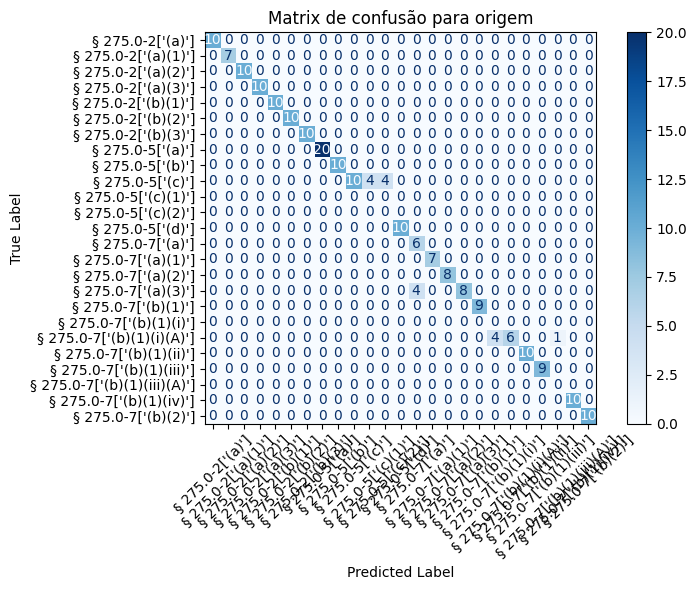

Classification Report:

                             precision    recall  f1-score   support

           § 275.0-2['(a)']     1.0000    1.0000    1.0000        10
        § 275.0-2['(a)(1)']     1.0000    1.0000    1.0000         7
        § 275.0-2['(a)(2)']     1.0000    1.0000    1.0000        10
        § 275.0-2['(a)(3)']     1.0000    1.0000    1.0000        10
        § 275.0-2['(b)(1)']     1.0000    1.0000    1.0000        10
        § 275.0-2['(b)(2)']     1.0000    1.0000    1.0000        10
        § 275.0-2['(b)(3)']     1.0000    1.0000    1.0000        10
           § 275.0-5['(a)']     1.0000    1.0000    1.0000        20
           § 275.0-5['(b)']     1.0000    1.0000    1.0000        10
           § 275.0-5['(c)']     1.0000    0.5556    0.7143        18
        § 275.0-5['(c)(1)']     0.0000    0.0000    0.0000         0
        § 275.0-5['(c)(2)']     0.0000    0.0000    0.0000         0
           § 275.0-5['(d)']     1.0000    1.0000    1.0000        10
         

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [48]:
create_df_elements_results_confusion_matrix_source(df_elements_results)

Analyzing the Distribution of Similarity Classifications

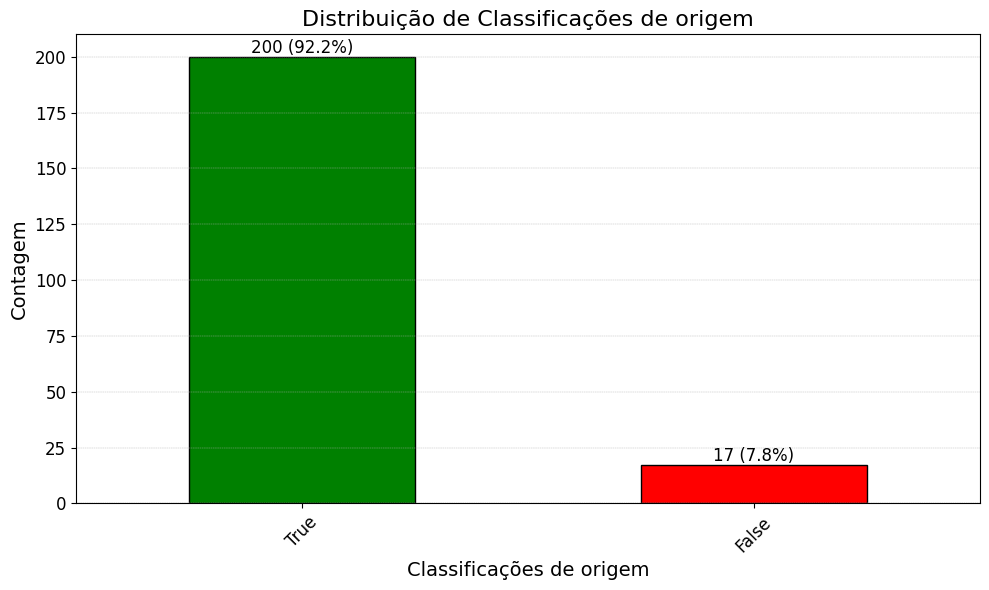

In [49]:
create_elements_results_distribution_source(df_elements_results)

##### Extract elements: term, and verb symbols (P1)

**Matching and missing terms**

In [51]:
terms_matches = []
terms_not_matches = []

for pred_term in pred_terms_extraction:#pred_terms_classify:

    statement_id = pred_term.get("statement_id")
    doc_id = pred_term.get("doc_id")
    sources = pred_term.get("sources")

    results = DeepSearch(
        true_terms_extraction,
        statement_id,
        verbose_level=2,
        case_sensitive=False,
        match_string=True,
    )
    logger.debug(results)
    if results:
        for item in list(results["matched_values"].keys()):
            idx, key = extract_index_and_key(item)
            # print(idx, key)
        terms_matches.append(true_terms_extraction[idx])
    else:
        terms_not_matches.append(pred_term)
        logger.debug(doc_id, sources, statement_id)
        logger.debug(results)

Total of matching and missing terms

In [52]:
len(terms_matches), len(terms_not_matches)

(997, 52)

Unique terms combining statement_id and sources

In [53]:
terms_not_matches

[{'statement_id': 'Power to sell',
  'classification': 'Common Noun',
  'sources': ('(b)(1)(i)',),
  'doc_id': '§ 275.0-7',
  'definition': None},
 {'statement_id': 'Right to receive',
  'classification': 'Common Noun',
  'sources': ('(b)(1)(ii)',),
  'doc_id': '§ 275.0-7',
  'definition': None},
 {'statement_id': 'Limited liability company',
  'classification': 'Common Noun',
  'sources': ('(b)(1)(iii)',),
  'doc_id': '§ 275.0-7',
  'definition': None},
 {'statement_id': 'Right to receive',
  'classification': 'Common Noun',
  'sources': ('(b)(1)(iii)',),
  'doc_id': '§ 275.0-7',
  'definition': None},
 {'statement_id': 'Desirability of a hearing',
  'classification': 'Common Noun',
  'sources': ('(a)',),
  'doc_id': '§ 275.0-5',
  'definition': None},
 {'statement_id': 'Own motion',
  'classification': 'Common Noun',
  'sources': ('(c)(2)',),
  'doc_id': '§ 275.0-5',
  'definition': None},
 {'statement_id': 'Right to receive',
  'classification': 'Common Noun',
  'sources': ('(b)(1)(

In [54]:
unique_terms_not_matches = Counter(
    [
        f'{term["doc_id"]}|{term["sources"]}|{term["statement_id"]}'
        for term in terms_not_matches
    ]
)

len(unique_terms_not_matches)

33

Distribution (without sources)

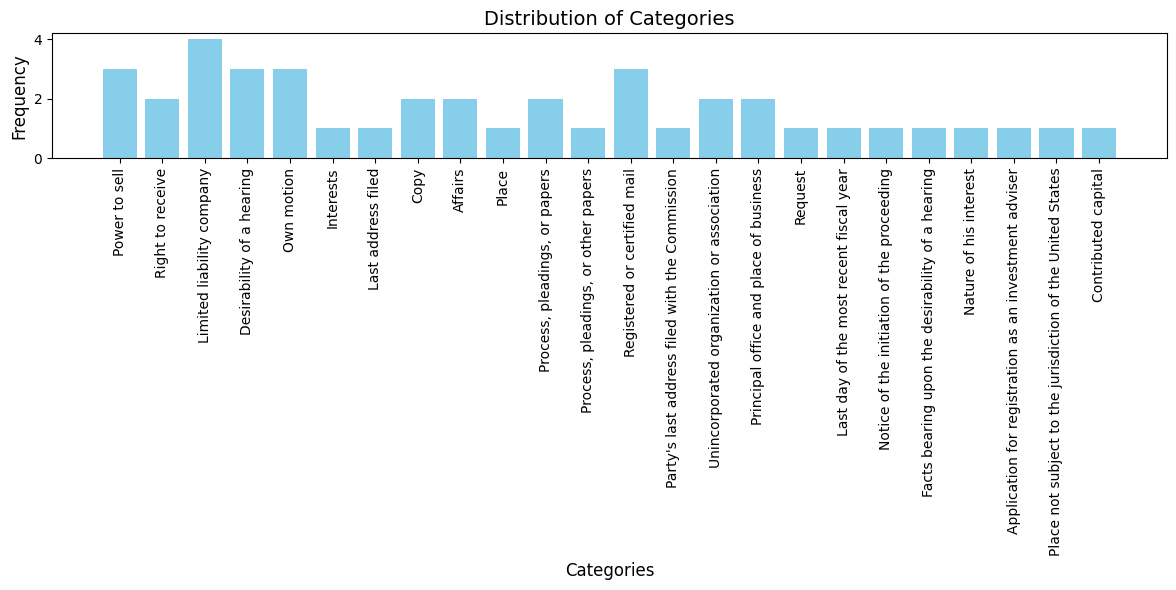

In [55]:
# Extract categories and frequencies
categories = [key.split("|")[2] for key in unique_terms_not_matches.keys()]
frequencies = list(unique_terms_not_matches.values())

# Create a distribution graph
plt.figure(figsize=(12, 6))
plt.bar(categories, frequencies, color="skyblue")
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Categories", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

Missing terms

In [56]:
unique_terms_not_matches

Counter({"§ 275.0-7|('(b)(1)(iii)',)|Limited liability company": 4,
         "§ 275.0-7|('(b)(1)(i)',)|Power to sell": 3,
         "§ 275.0-5|('(a)',)|Desirability of a hearing": 3,
         "§ 275.0-5|('(c)(2)',)|Own motion": 3,
         "§ 275.0-2|('(a)(2)',)|Registered or certified mail": 3,
         "§ 275.0-7|('(b)(1)(ii)',)|Right to receive": 2,
         "§ 275.0-2|('(a)(2)',)|Copy": 2,
         "§ 275.0-2|('(b)(1)',)|Affairs": 2,
         "§ 275.0-2|('(a)(1)',)|Process, pleadings, or papers": 2,
         "§ 275.0-2|('(b)(1)',)|Unincorporated organization or association": 2,
         "§ 275.0-2|('(b)(2)',)|Principal office and place of business": 2,
         "§ 275.0-2|('(b)(2)',)|Unincorporated organization or association": 2,
         "§ 275.0-2|('(b)(3)',)|Principal office and place of business": 2,
         "§ 275.0-7|('(b)(1)(iii)',)|Right to receive": 1,
         "§ 275.0-7|('(b)(1)(iii)(A)',)|Limited liability company": 1,
         "§ 275.0-7|('(b)(1)(iii)(A)',)|Interests"

Matching terms

In [57]:
unique_terms_matches = Counter(
    [
        f'{term["doc_id"]}|{term["sources"]}|{term["statement_id"]}'
        for term in terms_matches
    ]
)

len(unique_terms_matches)

68

In [58]:
len(true_terms_extraction)

122

In [59]:
unique_terms_matches

Counter({"§ 275.0-7|('(b)(2)',)|Person": 90,
         "§ 275.0-7|('(b)(2)',)|Investment adviser": 52,
         "§ 275.0-5|('(c)',)|Hearing": 38,
         "§ 275.0-7|('(b)(1)(ii)',)|Partnership": 30,
         "§ 275.0-2|('(a)(3)',)|Named party": 27,
         "§ 275.0-7|('(a)(3)',)|Assets under management": 25,
         "§ 275.0-7|('(b)(2)',)|Total assets": 25,
         "§ 275.0-2|('(a)(3)',)|Process": 22,
         "§ 275.0-2|('(a)(3)',)|Pleadings": 22,
         "§ 275.0-2|('(a)(3)',)|Papers": 22,
         "§ 275.0-7|('(b)(1)',)|Control": 21,
         "§ 275.0-7|('(b)(1)(iv)',)|Managing agent": 20,
         "§ 275.0-7|('(b)(1)(iv)',)|Trustee": 20,
         "§ 275.0-7|('(b)(1)(i)(A)',)|Corporation": 20,
         "§ 275.0-5|('(c)',)|Interested person": 20,
         "§ 275.0-5|('(b)',)|Period of time": 20,
         "§ 275.0-5|('(c)',)|Matter": 19,
         "§ 275.0-7|('(b)(1)(iii)',)|Right to vote": 18,
         "§ 275.0-2|('(a)(1)',)|Non-resident investment adviser": 17,
         "§ 275.0-

Distribution (without sources)

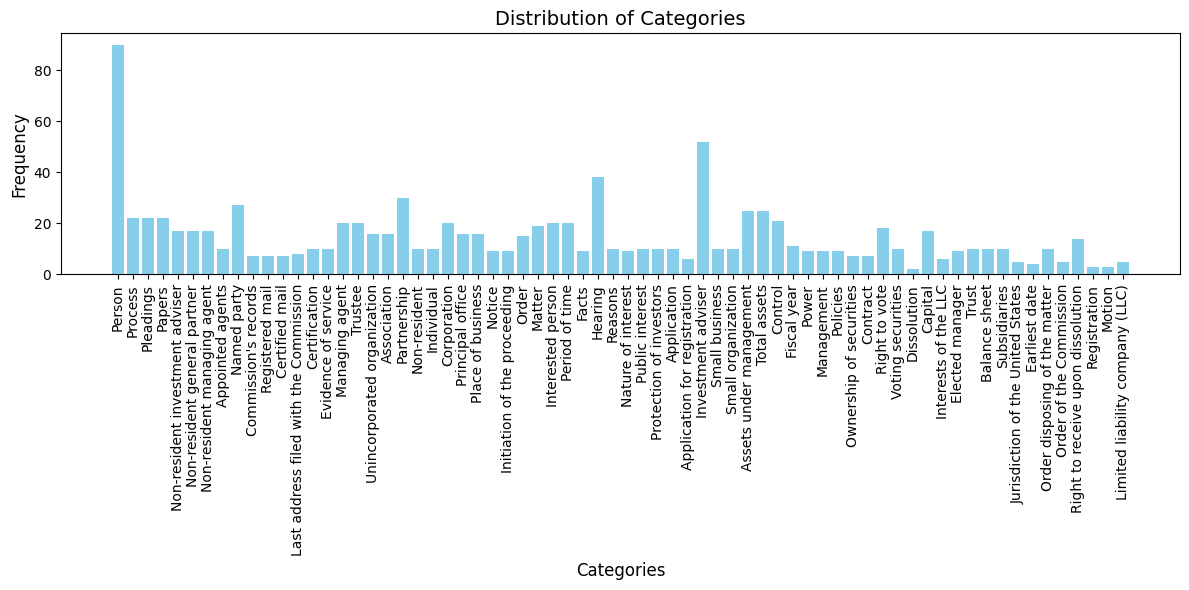

In [60]:
# Extract categories and frequencies
categories = [key.split("|")[2] for key in unique_terms_matches.keys()]
frequencies = list(unique_terms_matches.values())

# Create a distribution graph
plt.figure(figsize=(12, 6))
plt.bar(categories, frequencies, color="skyblue")
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Categories", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

Comparing pred vs true

In [61]:
# true_terms_list = set([f'{term["statement_id"]}|{term["doc_id"]}|{term["sources"]}' for term in true_terms_extraction])
true_terms_list = [
    f'{term["statement_id"]}|{term["doc_id"]}|{term["sources"]}'
    for term in true_terms_extraction
]

len(true_terms_list)

122

In [62]:
# pred_terms_list = set([f'{term["statement_id"]}|{term["doc_id"]}|{term["sources"]}' for term in pred_terms_classify])
pred_terms_list = [
    f'{term["statement_id"]}|{term["doc_id"]}|{term["sources"]}'
    for term in pred_terms_extraction
]

len(pred_terms_list)

1049

Metrics

In [63]:
def calculate_terms_metrics(true_list, pred_list):
    # Convert inputs to sets for efficient operations
    true_set = set(true_list)
    pred_set = set(pred_list)

    # Calculate components
    tp = len(true_set & pred_set)  # True Positives
    fp = len(pred_set - true_set)  # False Positives
    fn = len(true_set - pred_set)  # False Negatives
    tn = len(true_set) - tp - fp - fn  # True Negatives (using total terms)

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )
    accuracy = (tp + tn) / len(true_set) if len(true_set) > 0 else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Accuracy": accuracy,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
    }

In [64]:
metrics = calculate_terms_metrics(true_terms_list, pred_terms_list)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Precision: 0.6918604651162791
Recall: 0.9754098360655737
F1-Score: 0.8095238095238095
Accuracy: 0.5409836065573771
TP: 119
FP: 53
FN: 3
TN: -53


In [65]:
len(set(true_terms_list) - set(pred_terms_list)), len(
    set(pred_terms_list) - set(true_terms_list)
)

(3, 53)

FP - False Positive

In [66]:
sorted(set(pred_terms_list) - set(true_terms_list))

["Affairs|§ 275.0-2|('(b)(1)',)",
 "Application for registration as an investment adviser|§ 275.0-5|('(d)',)",
 "Contributed capital|§ 275.0-7|('(b)(1)(ii)',)",
 "Contributed capital|§ 275.0-7|('(b)(1)(iii)',)",
 "Control|§ 275.0-7|('(a)',)",
 "Copy|§ 275.0-2|('(a)(2)',)",
 "Corporation|§ 275.0-7|('(b)(1)(i)',)",
 "Desirability of a hearing|§ 275.0-5|('(a)',)",
 "Dissolution|§ 275.0-7|('(b)(1)(iii)',)",
 "Facts bearing upon the desirability of a hearing|§ 275.0-5|('(a)',)",
 "Hearing|§ 275.0-5|('(c)(1)',)",
 "Hearing|§ 275.0-5|('(c)(2)',)",
 "Interested person|§ 275.0-5|('(c)(1)',)",
 "Interests|§ 275.0-7|('(b)(1)(iii)',)",
 "Interests|§ 275.0-7|('(b)(1)(iii)(A)',)",
 "Last address filed|§ 275.0-2|('(a)(2)',)",
 "Last day of the most recent fiscal year|§ 275.0-7|('(a)(2)',)",
 "Limited liability company|§ 275.0-7|('(b)(1)(iii)',)",
 "Limited liability company|§ 275.0-7|('(b)(1)(iii)(A)',)",
 "Matter|§ 275.0-5|('(c)(1)',)",
 "Matter|§ 275.0-5|('(c)(2)',)",
 "Motion|§ 275.0-5|('(c)(2)',)

Grouped

In [67]:
len(group_and_count_not_in_true(pred_terms_list, true_terms_list).keys())

53

In [68]:
group_and_count_not_in_true(pred_terms_list, true_terms_list)

{"Affairs|§ 275.0-2|('(b)(1)',)": 2,
 "Application for registration as an investment adviser|§ 275.0-5|('(d)',)": 1,
 "Contributed capital|§ 275.0-7|('(b)(1)(ii)',)": 1,
 "Contributed capital|§ 275.0-7|('(b)(1)(iii)',)": 1,
 "Control|§ 275.0-7|('(a)',)": 4,
 "Copy|§ 275.0-2|('(a)(2)',)": 2,
 "Corporation|§ 275.0-7|('(b)(1)(i)',)": 4,
 "Desirability of a hearing|§ 275.0-5|('(a)',)": 3,
 "Dissolution|§ 275.0-7|('(b)(1)(iii)',)": 1,
 "Facts bearing upon the desirability of a hearing|§ 275.0-5|('(a)',)": 1,
 "Hearing|§ 275.0-5|('(c)(1)',)": 4,
 "Hearing|§ 275.0-5|('(c)(2)',)": 4,
 "Interested person|§ 275.0-5|('(c)(1)',)": 4,
 "Interests|§ 275.0-7|('(b)(1)(iii)',)": 1,
 "Interests|§ 275.0-7|('(b)(1)(iii)(A)',)": 1,
 "Last address filed|§ 275.0-2|('(a)(2)',)": 1,
 "Last day of the most recent fiscal year|§ 275.0-7|('(a)(2)',)": 1,
 "Limited liability company|§ 275.0-7|('(b)(1)(iii)',)": 4,
 "Limited liability company|§ 275.0-7|('(b)(1)(iii)(A)',)": 1,
 "Matter|§ 275.0-5|('(c)(1)',)": 2,
 "M

FN - False Negative

In [69]:
set(true_terms_list) - set(pred_terms_list)

{"Last address|§ 275.0-2|('(a)(2)',)",
 "Natural person|§ 275.0-7|('(a)(3)',)",
 "Securities|§ 275.0-7|('(b)(1)',)"}

**Matching and missing names**

In [70]:
names_matches = []
names_not_matches = []

for pred_names in pred_names_extraction:

    statement_id = pred_names.get("statement_id")

    results = DeepSearch(
        true_names_extraction,
        statement_id,
        verbose_level=2,
        case_sensitive=False,
        match_string=True,
    )
    if results:
        for item in list(results["matched_values"].keys()):
            idx, key = extract_index_and_key(item)
            # print(idx, key)
        names_matches.append(true_names_extraction[idx])
    else:
        names_not_matches.append(pred_names)

Total of matching and missing names

In [71]:
len(names_matches), len(names_not_matches)

(121, 7)

Unique names combining statement_id and sources

In [72]:
unique_names_not_matches = Counter(
    [
        f'{name["doc_id"]}|{name["sources"]}|{name["statement_id"]}'
        for name in names_not_matches
    ]
)

len(unique_names_not_matches)

1

In [73]:
unique_names_not_matches

Counter({"§ 275.0-7|('(a)(1)',)|Section 203A(a)(1)(A) of the Act": 7})

Distribution (without sources) - Not match

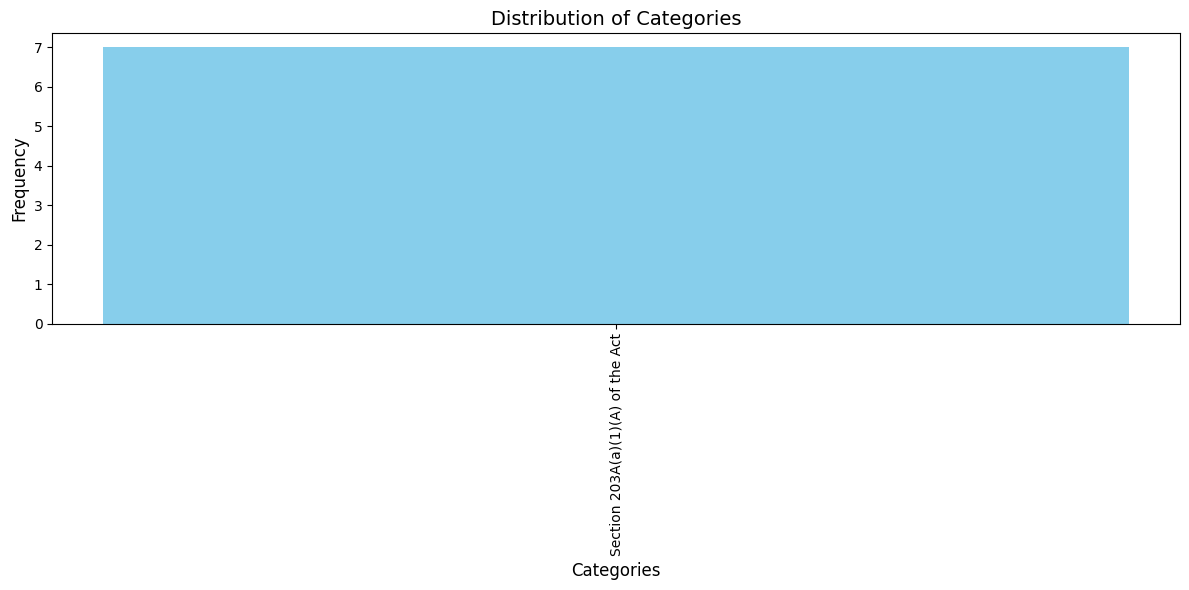

In [74]:
# Extract categories and frequencies
categories = [key.split("|")[2] for key in unique_names_not_matches.keys()]
frequencies = list(unique_names_not_matches.values())

# Create a distribution graph
plt.figure(figsize=(12, 6))
plt.bar(categories, frequencies, color="skyblue")
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Categories", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

Matching names

In [75]:
names_unique_matches = Counter(
    [
        f'{name["doc_id"]}|{name["sources"]}|{name["statement_id"]}'
        for name in names_matches
    ]
)

len(names_unique_matches)

5

In [76]:
names_unique_matches

Counter({"§ 275.0-7|('(a)(1)',)|Commission": 81,
         "§ 275.0-2|('(a)(2)',)|Secretary of the Commission": 10,
         "§ 275.0-2|('(a)(3)',)|Secretary": 10,
         "§ 275.0-5|('(a)',)|Federal Register": 10,
         "§ 275.0-5|('(d)',)|Act": 10})

Distribution (without sources) - Match

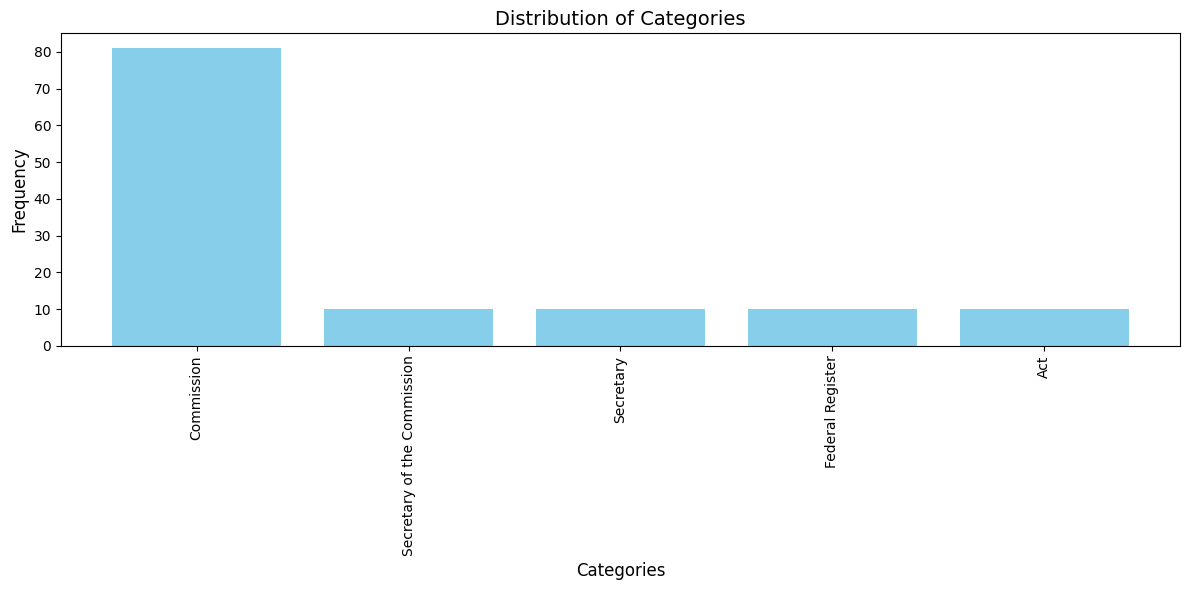

In [77]:
# Extract categories and frequencies
categories = [key.split("|")[2] for key in names_unique_matches.keys()]
frequencies = list(names_unique_matches.values())

# Create a distribution graph
plt.figure(figsize=(12, 6))
plt.bar(categories, frequencies, color="skyblue")
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Categories", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

Metrics

In [78]:
# true_terms_list = set([f'{term["statement_id"]}|{term["doc_id"]}|{term["sources"]}' for term in true_terms_extraction])
true_names_list = [
    f'{name["statement_id"]}|{name["doc_id"]}|{name["sources"]}'
    for name in true_names_extraction
]

len(true_names_list)

14

In [79]:
# pred_terms_list = set([f'{term["statement_id"]}|{term["doc_id"]}|{term["sources"]}' for term in pred_terms_classify])
pred_names_list = [
    f'{name["statement_id"]}|{name["doc_id"]}|{name["sources"]}'
    for name in pred_names_extraction
]

len(pred_names_list)

128

In [80]:
true_names_list

["Commission|§ 275.0-2|('(a)(1)',)",
 "Commission|§ 275.0-2|('(a)(2)',)",
 "Secretary of the Commission|§ 275.0-2|('(a)(2)',)",
 "Commission|§ 275.0-2|('(a)(3)',)",
 "Secretary|§ 275.0-2|('(a)(3)',)",
 "Federal Register|§ 275.0-5|('(a)',)",
 "Commission|§ 275.0-5|('(a)',)",
 "Commission|§ 275.0-5|('(b)',)",
 "Commission|§ 275.0-5|('(c)',)",
 "Act|§ 275.0-5|('(d)',)",
 "Commission|§ 275.0-5|('(d)',)",
 "Commission|§ 275.0-7|('(a)',)",
 "Commission|§ 275.0-7|('(a)(1)',)",
 "Form ADV|§ 275.0-7|('(a)(1)',)"]

In [81]:
set(pred_names_list ) - set(true_names_list)

{"Commission|§ 275.0-5|('(c)(1)',)",
 "Commission|§ 275.0-5|('(c)(2)',)",
 "Section 203A(a)(1)(A) of the Act|§ 275.0-7|('(a)(1)',)"}

In [82]:
metrics = calculate_terms_metrics(true_names_list, pred_names_list)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Precision: 0.8125
Recall: 0.9285714285714286
F1-Score: 0.8666666666666666
Accuracy: 0.7142857142857143
TP: 13
FP: 3
FN: 1
TN: -3


Semantic similarity

In [83]:
len(
    set(
        [
            f'{item["doc_id"]}|{item["sources"]}|{item["statement_id"]}'
            for item in true_terms_extraction
        ]
    )
)

122

In [84]:
len(
    set(
        [
            f'{item["doc_id"]}|{item["sources"]}|{item["statement_id"]}'
            for item in pred_terms_extraction
        ]
    )
)

172

In [85]:
# Run the similarity check
similarity_terms_results = check_for_definitions_similarity(
    true_terms_extraction, pred_terms_extraction
)

2025-01-11 17:46:41 - INFO - Total terms in true_terms: 122


2025-01-11 17:46:41 - INFO - Total matched terms in pred_terms: 119


Create a dataframe of true and pred elements

In [86]:
df_terms_results = create_df_terms_results(similarity_terms_results)

Histogram of Similarity Scores

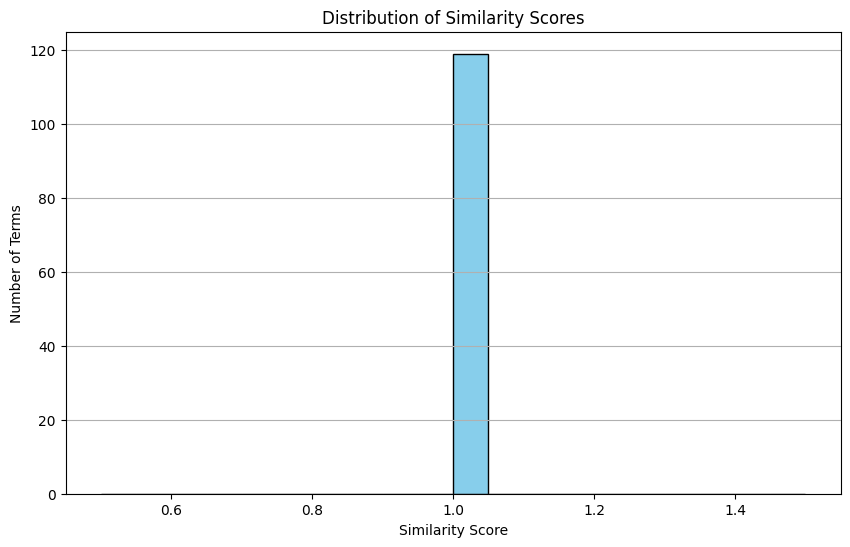

In [87]:
create_terms_results_distribution_similarity(df_terms_results)

Terms with Lowest Similarity Scores

In [88]:
# Count records with similarity_score equal to 0
count_zero_similarity = df_terms_results[
    df_terms_results["similarity_score"] == 0
].shape[0]

print(f"Number of records with similarity_score equal to 0 is {count_zero_similarity}")

Number of records with similarity_score equal to 0 is 0


In [89]:
# Identify Terms with Low Similarity Scores
df_sorted = df_terms_results.sort_values(by="similarity_score")

print("Top 10 Terms with Lowest Similarity Scores:")
display(df_sorted.head(10))

Top 10 Terms with Lowest Similarity Scores:


,doc_id,sources,term,definition_pred,definition_true,similarity_score
0,§ 275.0-2,"((a),)",person,None,,1
86,§ 275.0-7,"((b)(1),)",contract,None,,1
85,§ 275.0-7,"((b)(1),)",ownership of securities,None,,1
84,§ 275.0-7,"((b)(1),)",person,None,,1
83,§ 275.0-7,"((b)(1),)",policies,None,,1
82,§ 275.0-7,"((b)(1),)",management,None,,1
81,§ 275.0-7,"((b)(1),)",power,None,,1
80,§ 275.0-7,"((b)(1),)",control,None,,1
79,§ 275.0-7,"((a)(3),)",fiscal year,None,,1
78,§ 275.0-7,"((a)(3),)",person,None,,1


Visualize Low Similarity Terms with a Bar Chart

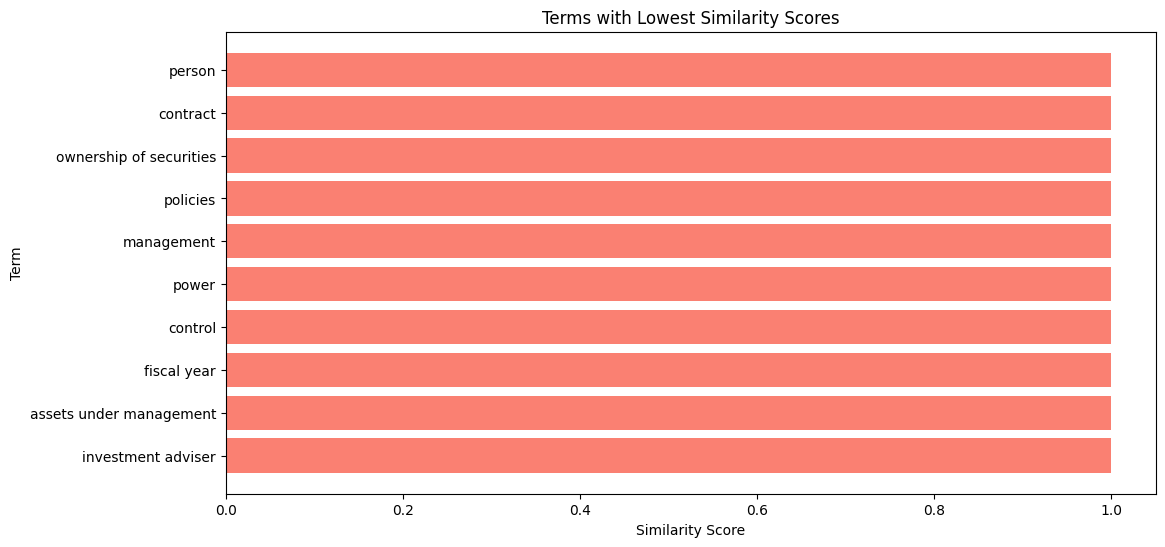

In [90]:
create_terms_results_histogram_low_similarity(df_terms_results, number_of_terms=20)

Analyze Similarity Scores by Document

Average Similarity Score per Document:


,doc_id,similarity_score
0,§ 275.0-2,1.0
1,§ 275.0-5,1.0
2,§ 275.0-7,1.0


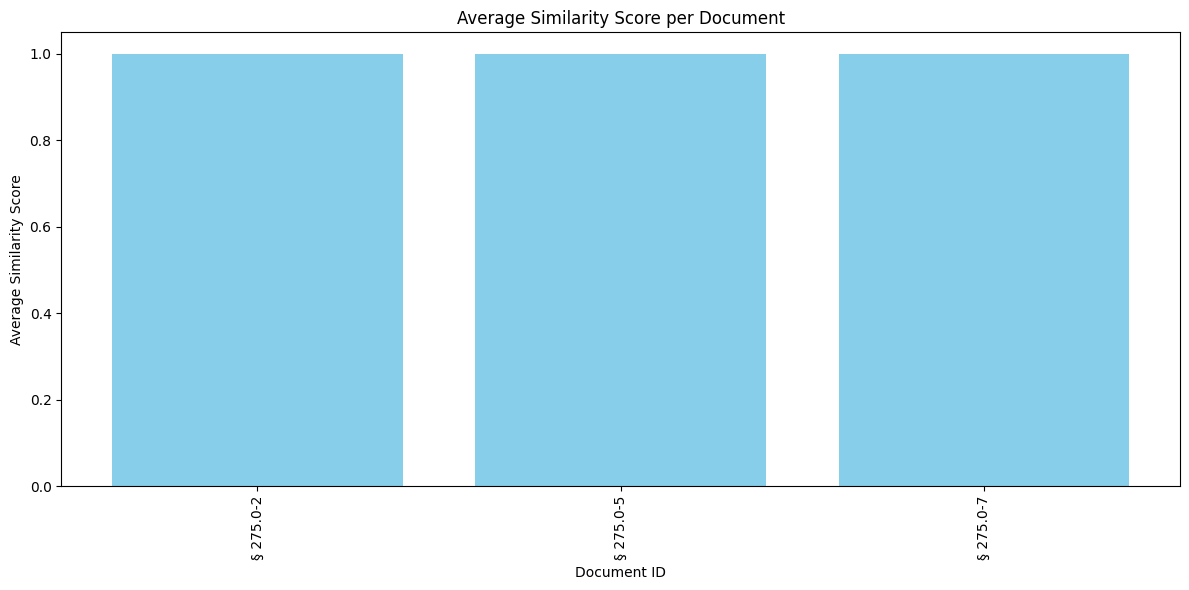

In [91]:
create_terms_results_average_similarity_per_document(df_terms_results)

Heatmap of Similarity Scores

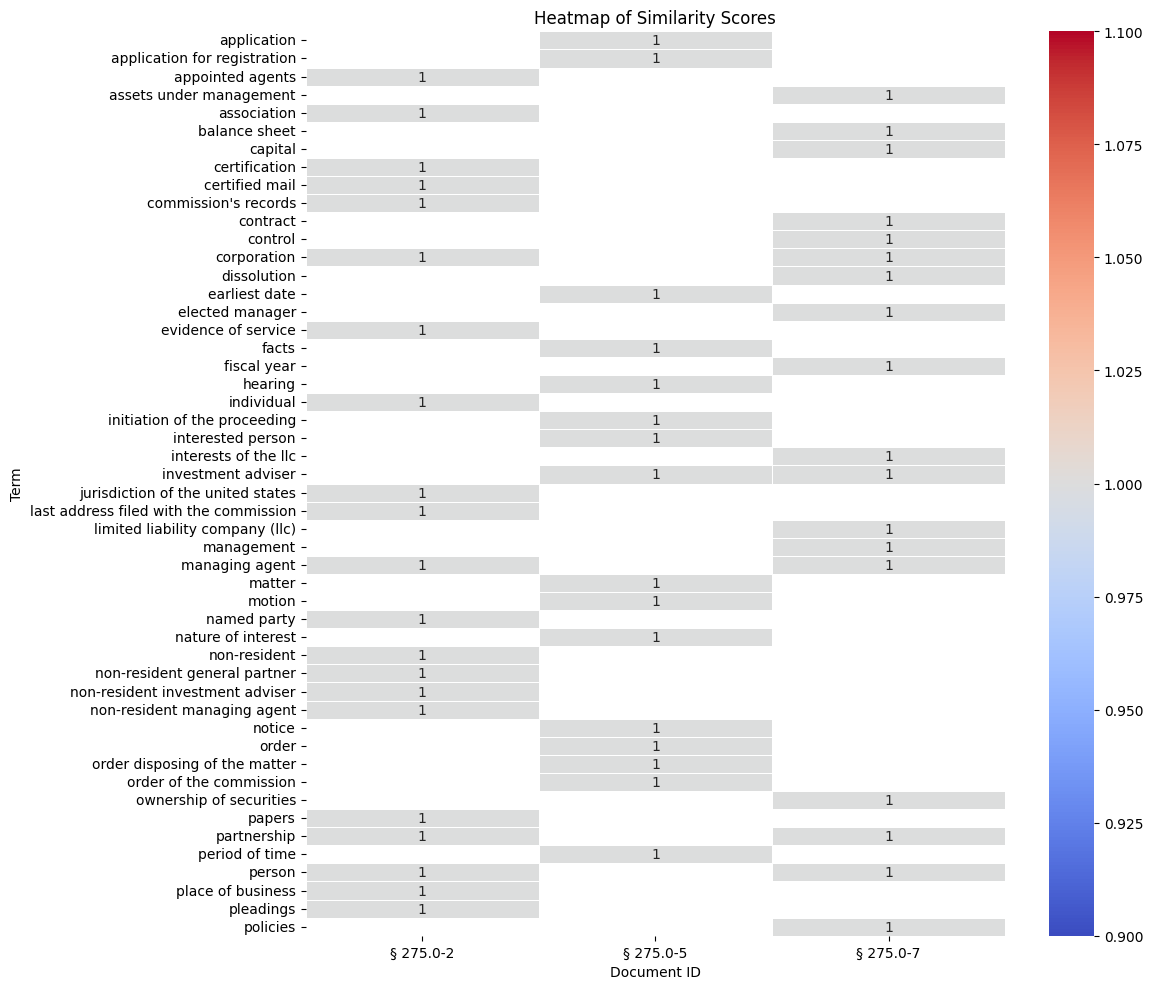

In [92]:
create_terms_results_heatmap(df_terms_results)

Save Similarity Results to Excel

In [86]:
excel_filename = f'{config["DEFAULT_OUTPUT_DIR"]}/extract_p2_true_pred_results.xlsx'
df_terms_results.to_excel(excel_filename, index=False)

logger.info(f"Similarity results saved to '{excel_filename}'")

2024-12-21 21:43:21 - INFO - Similarity results saved to '../outputs/extract_p2_true_pred_results.xlsx'
